<a href="https://colab.research.google.com/github/hphp777/GraduationProject01/blob/main/chest_X_ray_Keggle_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q efficientnet

     |████████████████████████████████| 51kB 3.3MB/s 


In [ ]:
# 필요한 라이브러리 전부 임포트
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.image import * 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import random
import io
import tensorflow as tf
from tensorflow import optimizers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.layers as L
import tensorflow_hub as hub
import shutil

import efficientnet.tfkeras as efn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
all_xray_df = pd.read_csv('/content/drive/MyDrive/GraduationProject/Data_Entry_2017.csv')
BBox_List = pd.read_csv('/content/drive/MyDrive/GraduationProject/BBox_List_2017.csv')
train_df = pd.read_csv('/content/drive/MyDrive/GraduationProject/train_df.csv')

In [ ]:
# 이미지이름: 이미지경로 를 만들어주는 딕셔너리
all_image_paths = {os.path.basename(x): x for x in 
                   glob('/content/drive/MyDrive/GraduationProject/images/images*/images/*.png')}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

Scans found: 112183 , Total Headers 112120


In [ ]:
train_df_main = pd.read_csv('/content/drive/MyDrive/GraduationProject/train_df.csv')
# valid_df = pd.read_csv("nih/valid-small.csv")
# test_df = pd.read_csv("nih/test.csv")

# 이미지이름: 이미지경로 를 만들어주는 딕셔너리
all_image_paths = {os.path.basename(x): x for x in 
                   glob('/content/drive/MyDrive/GraduationProject/images/images*/images/*.png')}
train_df_main['FilePath'] = train_df_main['Image Index'].map(all_image_paths.get)

In [ ]:
train_df_main.drop(['No Finding'], axis = 1, inplace = True)
labels = train_df_main.columns[2:-1]
labels

Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [ ]:
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['path']

0         /content/drive/MyDrive/GraduationProject/image...
1         /content/drive/MyDrive/GraduationProject/image...
2         /content/drive/MyDrive/GraduationProject/image...
3         /content/drive/MyDrive/GraduationProject/image...
4         /content/drive/MyDrive/GraduationProject/image...
                                ...                        
112115    /content/drive/MyDrive/GraduationProject/image...
112116    /content/drive/MyDrive/GraduationProject/image...
112117    /content/drive/MyDrive/GraduationProject/image...
112118    /content/drive/MyDrive/GraduationProject/image...
112119    /content/drive/MyDrive/GraduationProject/image...
Name: path, Length: 112120, dtype: object

In [ ]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/content/drive/MyDrive/GraduationProject/image...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/content/drive/MyDrive/GraduationProject/image...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/content/drive/MyDrive/GraduationProject/image...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/content/drive/MyDrive/GraduationProject/image...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/content/drive/MyDrive/GraduationProject/image...


In [ ]:
all_xray_df['Patient Age'] = list(map(int, all_xray_df['Patient Age']))

In [ ]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
567,00000138_004.png,Nodule,4,138,65,F,PA,2822,2541,0.143,0.143,NaN,/content/drive/MyDrive/GraduationProject/image...
46718,00011925_043.png,Effusion|Mass,43,11925,54,M,PA,2500,2048,0.168,0.168,NaN,/content/drive/MyDrive/GraduationProject/image...
14080,00003647_000.png,Atelectasis,0,3647,41,M,AP,2500,2048,0.171,0.171,NaN,/content/drive/MyDrive/GraduationProject/image...


# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

In [ ]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

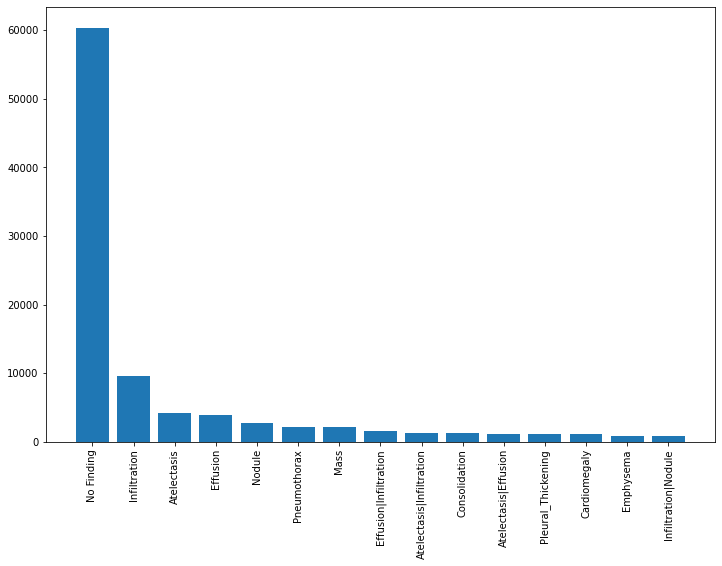

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

In [ ]:
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [ ]:
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
395,00000099_004.png,Infiltration,4,99,56,F,PA,2272,2526,0.143,0.143,NaN,/content/drive/MyDrive/GraduationProject/image...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16622,00004448_000.png,,0,4448,29,F,PA,2048,2500,0.171,0.171,NaN,/content/drive/MyDrive/GraduationProject/image...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4984,00001332_002.png,Consolidation|Infiltration,2,1332,17,M,AP,2500,2048,0.168,0.168,NaN,/content/drive/MyDrive/GraduationProject/image...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


**Clean categories**

Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [ ]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


In [ ]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

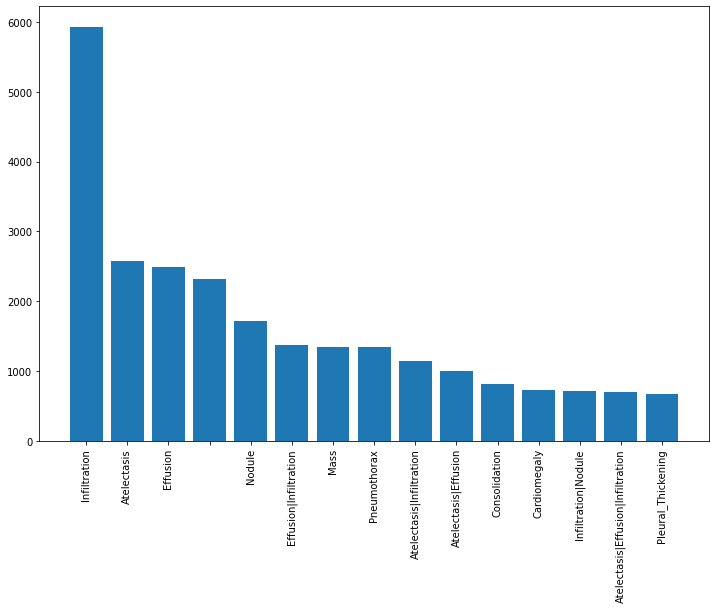

In [ ]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

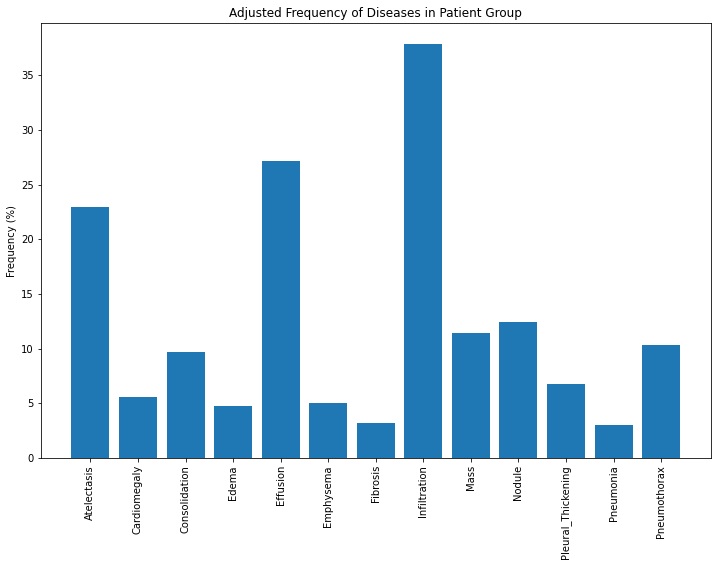

In [ ]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [ ]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [ ]:
all_xray_df['disease_vec']

1150      [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...
6319      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
95643     [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...
107545    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
4378      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                ...                        
96401     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
89296     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
91866     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
36717     [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
836       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
Name: disease_vec, Length: 40000, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(all_xray_df, 
                                   test_size = 0.3, 
                                   random_state = 2021,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4])) # 중복을 허용해주면 안됨

test_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.5, 
                                   random_state = 2021,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4])) # 중복을 허용해주면 안됨
                                   

print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 28000 validation 20000


# 변형된 이미지

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)

core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

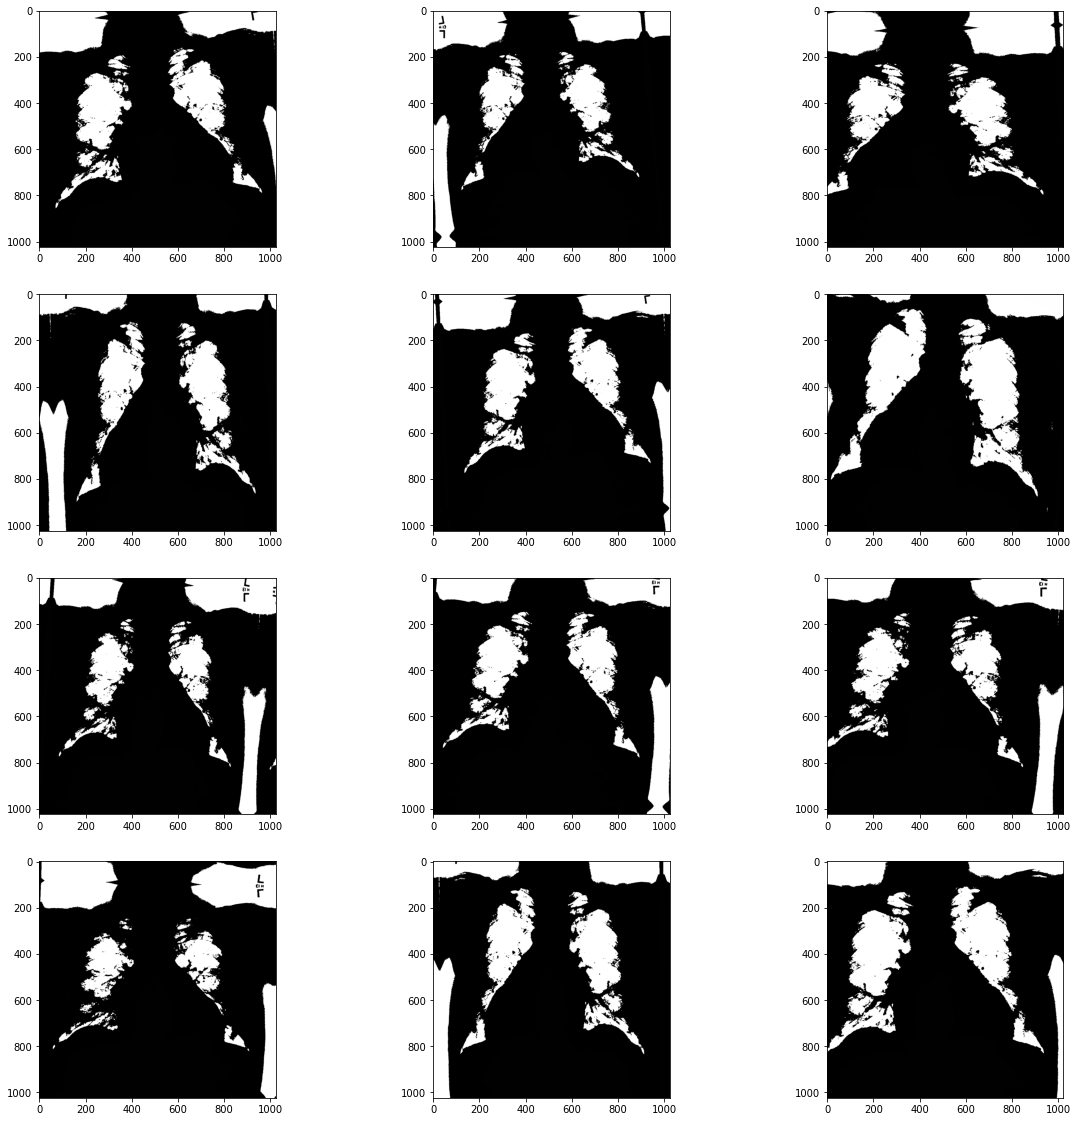

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

image = load_img(all_xray_df['path'][0])
data = img_to_array(image)
samples = expand_dims(data,0)
it = core_idg.flow(samples, batch_size = 1)
fig = plt.figure(figsize = (20,20))
for i in range(12) :
  plt.subplot(4,3,1+i)
  batch = it.next()
  image = batch[0].astype('uint8')
  plt.imshow(image)
plt.show()

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [ ]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
directory=None,
x_col = 'path',
y_col = 'newLabel',
class_mode = 'categorical',
classes = all_labels,
target_size = IMG_SIZE,
color_mode = 'grayscale',
batch_size = 32)

Found 26331 validated image filenames belonging to 13 classes.


In [ ]:
valid_X, valid_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
directory=None,
x_col = 'path',
y_col = 'newLabel',
class_mode = 'categorical',
classes = all_labels,
target_size = IMG_SIZE,
color_mode = 'grayscale',
batch_size = 1024))

Found 18809 validated image filenames belonging to 13 classes.


In [ ]:
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=test_df,
directory=None,
x_col = 'path',
y_col = 'newLabel',
class_mode = 'categorical',
classes = all_labels,
target_size = IMG_SIZE,
color_mode = 'grayscale',
batch_size = 1024))

Found 18810 validated image filenames belonging to 13 classes.


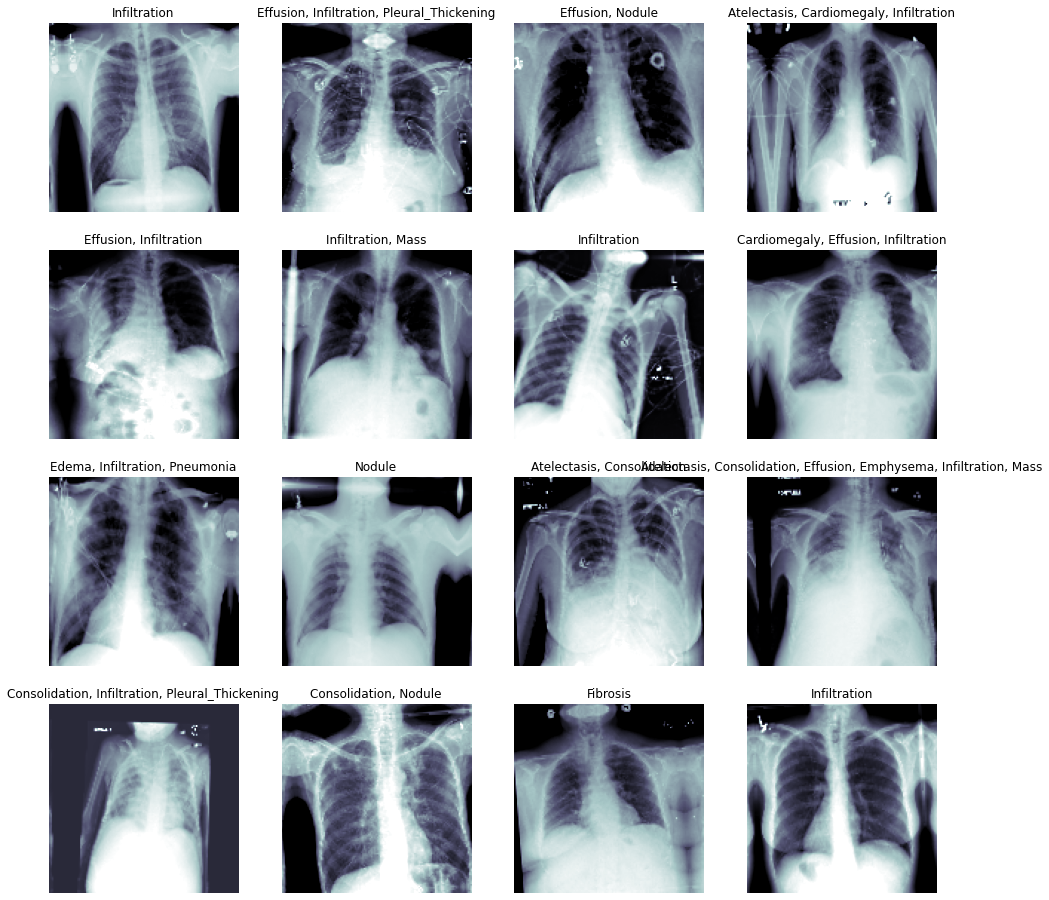

In [ ]:
# create training set
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Create a simple model
Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(BatchNormalization())
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 13)                6669      
Total params: 3,761,805
Trainable params: 3,738,893
Non-trainable params: 22,912
_______________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (valid_X, valid_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 736s 7s/step - loss: 0.7573 - binary_accuracy: 0.6037 - mae: 0.4605 - val_loss: 0.4153 - val_binary_accuracy: 0.8637 - val_mae: 0.3096

Epoch 00001: val_loss improved from inf to 0.41532, saving model to xray_class_weights.best.hdf5


# Check Output
Here we see how many positive examples we have of each category

In [ ]:
for c_label, s_count in zip(all_labels, 100*np.mean(valid_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 25.00%
Cardiomegaly: 5.96%
Consolidation: 9.47%
Edema: 6.25%
Effusion: 29.39%
Emphysema: 5.86%
Fibrosis: 4.10%
Infiltration: 41.41%
Mass: 14.06%
Nodule: 13.28%
Pleural_Thickening: 7.91%
Pneumonia: 2.54%
Pneumothorax: 12.01%


In [ ]:
pred_Y = multi_disease_model.predict(valid_X, batch_size = 32, verbose = True)

32/32 [==============================] - 3s 17ms/step


# ROC Curves
While a very oversimplified metric, we can show the ROC curve for each metric

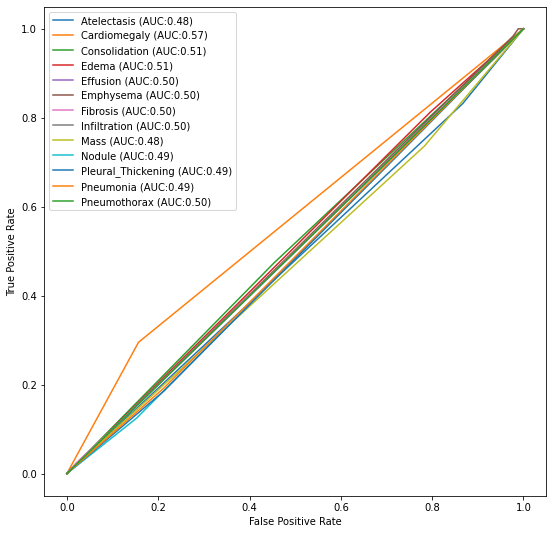

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(valid_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

# Continued Training
Now we do a much longer training process to see how the results improve

In [ ]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 [==============================] - 706s 7s/step - loss: 0.3621 - binary_accuracy: 0.8661 - mae: 0.2340 - val_loss: 0.3459 - val_binary_accuracy: 0.8665 - val_mae: 0.2081

Epoch 00001: val_loss improved from 0.41532 to 0.34588, saving model to xray_class_weights.best.hdf5
Epoch 2/5
100/100 [==============================] - 557s 6s/step - loss: 0.3483 - binary_accuracy: 0.8670 - mae: 0.2051 - val_loss: 0.3472 - val_binary_accuracy: 0.8665 - val_mae: 0.2058

Epoch 00002: val_loss did not improve from 0.34588
Epoch 3/5
100/100 [==============================] - 499s 5s/step - loss: 0.3448 - binary_accuracy: 0.8679 - mae: 0.2012 - val_loss: 0.3481 - val_binary_accuracy: 0.8665 - val_mae: 0.1962

Epoch 00003: val_loss did not improve from 0.34588
Epoch 4/5
100/100 [==============================] - 490s 5s/step - loss: 0.3453 - binary_accuracy: 0.8680 - mae: 0.2013 - val_loss: 0.3501 - val_binary_accuracy: 0.8665 - val_mae: 0.1946

Epoch 00004: val_loss did not improve fro

In [ ]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

32/32 [==============================] - 1s 17ms/step


In [ ]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 22.66%, PDx: 18.74%
Cardiomegaly: Dx: 5.47%, PDx: 7.61%
Consolidation: Dx: 9.47%, PDx: 8.98%
Edema: Dx: 6.15%, PDx: 5.28%
Effusion: Dx: 30.27%, PDx: 25.93%
Emphysema: Dx: 5.76%, PDx: 4.91%
Fibrosis: Dx: 2.34%, PDx: 4.98%
Infiltration: Dx: 42.09%, PDx: 40.11%
Mass: Dx: 14.55%, PDx: 12.77%
Nodule: Dx: 15.33%, PDx: 14.63%
Pleural_Thickening: Dx: 5.86%, PDx: 9.05%
Pneumonia: Dx: 2.93%, PDx: 3.62%
Pneumothorax: Dx: 10.64%, PDx: 14.97%


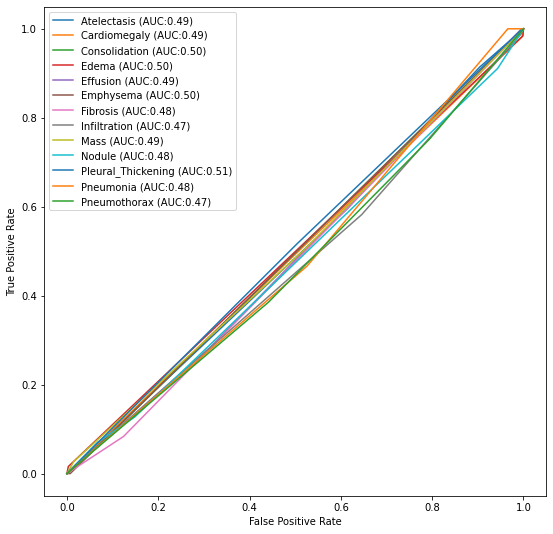

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

# Show a few images and associated predictions

In [ ]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')